# 3.6.1 Credit Card Fraud Challenge

__Data Source:__ [Kaggle Data Set](https://www.kaggle.com/mlg-ulb/creditcardfraud)

__Description (from Kaggle Site):__ The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
#necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score 
from sklearn.metrics import confusion_matrix

%matplotlib inline

__Importing and Initial Explortation of Data:__

In [2]:
cc_data = pd.read_csv('creditcard.csv')
cc_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#inspecting for null values
cc_data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

There are no null values in this data set.  Since this data has already been processed through PCA (according to the Kaggle site), this data has already been cleaned and null values removed. 

Next, let's check the spread of the target variable, Class.

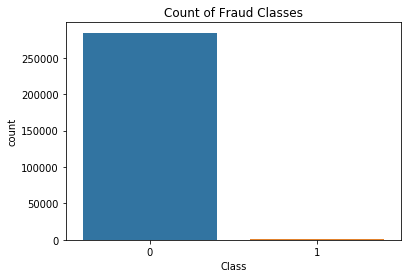

0    284315
1       492
Name: Class, dtype: int64

Number of Transactions in Data Set: 284807
Percent Fraud: 0.1727485630620034


In [4]:
sns.countplot('Class', data=cc_data)
plt.title('Count of Fraud Classes')
plt.show()

print(cc_data.Class.value_counts())
print('\nNumber of Transactions in Data Set: {}\nPercent Fraud: {}'.format(
    len(cc_data['Class']),
    len(cc_data[cc_data['Class']==1])/len(cc_data['Class'])*100))

Only 0.17% of the transactions in this data set are actually fraud.  This means that the data set is incredibly unbalanced.  Since nearly 500 transactions are fraudulent, we can apply undersampling to the data set to make the data set balanced for training the model.  Before undersampling, I will separate the data into train and test sets.

In [5]:
#Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    cc_data.drop('Class', axis=1), 
    cc_data['Class'],
    test_size=0.20)

print('Training Set Percent Fraut: {}'.format(
    len(y_train[y_train == 1])/len(y_train)*100))
print('Test Set Percent Fraud: {}'.format(
    len(y_test[y_test == 1])/len(y_test)*100))

Training Set Percent Fraut: 0.1746801553687814
Test Set Percent Fraud: 0.1650222955654647


The training and test set both have similar percent of fraudulent transactions as the data set as a whole.  This is necessary for fair training and test data sets.  Continue witn under sampling. 

In [6]:
#Under sampling 
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)

print('Resampled Training Set Percent Fraud: {}'.format(
    len(y_rus[y_rus == 1])/len(y_rus)*100))

Resampled Training Set Percent Fraud: 50.0


The re-sampled data set now has half fraudulent charges and half non-fraudulent charges.  This re-sampled data set is now unbiased and we can continue training models.  We will use the test set, which was not under-sampled to determine how well the model predicts the outcomes.

## Modleing: Logistic Regression with Under Sampled Data

With this undersampled data, there are now 50% fraudulent data points and 50% unfraudulent data.  This way the model can be trained with data that is half of each target value.  This will allow the accuracy analysis to be less biased to determine if the model is able to identify the fraudulent transactions.

I will use a logistic regression model with L1 penalty to hone in on the best features in the data.

In [7]:
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV(Cs=[1,10,50,100,500], 
                               penalty='l1',
                         solver='liblinear')
lr.fit(X_rus, y_rus)
print(lr.score(X_rus, y_rus))

0.957286432160804


This logistic regression model correctly predicted 95% of the undersampled data.  Let's continue to inspect the model and its efficacy through identifying the optimum C value, the coefficients, and intercept.

In [8]:
print(lr.C_)
print(lr.coef_)
print(lr.intercept_)

[1]
[[-9.33178215e-06  1.86764293e-01  1.03889245e-01 -9.53043336e-02
   9.13528934e-01  4.04222180e-01 -4.82980420e-01 -3.99818709e-02
  -4.92065437e-01 -2.43937403e-01 -6.31879014e-01  4.28707626e-01
  -8.03189553e-01 -3.26925603e-01 -1.22761998e+00 -1.01049695e-01
  -2.33668973e-01 -9.84039496e-02  1.29721186e-02 -6.94956001e-02
   1.39085720e-01 -5.31806677e-02  6.98096402e-01  0.00000000e+00
   0.00000000e+00 -3.35249327e-01 -2.90449727e-01  0.00000000e+00
   0.00000000e+00  2.39946388e-03]]
[-2.77208445]


Now, let's inspect the accuracy and precision of the model through a confusion matrix.  We're most concerned with correctly labeling fraudulent cases as such, therefore minimizing the false negatives.  For these cases, we should look at the recall statistic to determine how well the model is performing.

Recall for this model is: 0.9271356783919598


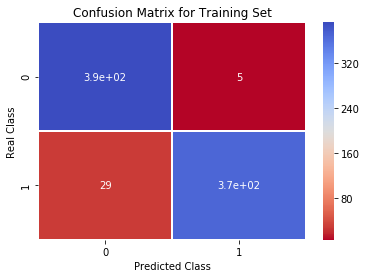

In [9]:
#using model to predict undersampled training set and construct confusion matrix
y_pred = lr.predict(X_rus)
conf_matrix = confusion_matrix(y_rus, y_pred)
#calculating recall from confusion matrix
recall = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0])
print('Recall for this model is: {}'.format(recall))

#creating heatmap of confusion matrix
sns.heatmap(conf_matrix, 
            cmap='coolwarm_r', 
            annot=True, 
            linewidths=0.5)
plt.title('Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

The recall for this model is 92.75%, which is fairly high for the model.  Only 26 fraudulent cases were predicted to be non-fraudulent.  The other 370 were predicted correctly. Let's check the test set for the model's recall.

__Test Set Recall__

Recall for the Test Set is: 0.9361702127659575


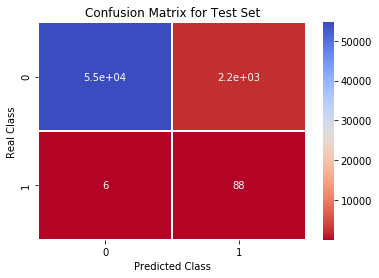

In [10]:
#using model to predict test set and construct confusion matrix
y_test_pred = lr.predict(X_test)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
#calculating recall from confusion matrix
recall_test = conf_matrix_test[1,1]/(conf_matrix_test[1,1]+conf_matrix_test[1,0])
print('Recall for the Test Set is: {}'.format(recall_test))

#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_test,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('Confusion Matrix for Test Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

The test set recall increased to 93%.  Only 6 of the 94 fraudulent cases were mis-labeled through this model.  This is a fairly high percent of recall.  In inspecting the confusion matrix, 2200 non-fraudulent transactions were identified, which is costly for the man-power required for customers to identify that the transaction is authentic, but there were still 55,000 non-fraudulent charges identified as such. 

Let's try SVM classifier as a second model to see how well that performs in comparison.

## Modeling: SVM Classifier with Under Sampled Data

In [ ]:
from sklearn.svm import SVC

svc = SVC()
parameters = [{'kernel': ['rbf'], 'C': [0.1,1,10,50], 'gamma':[0.0001,0.001]},
             {'kernel': ['linear'], 'C': [0.1,1,10,50]}]
grid = GridSearchCV(svc, param_grid=parameters)
grid.fit(X_rus, y_rus)
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
#using model to predict undersampled training set and construct confusion matrix
y_pred_svc = svc.predict(X_rus)
conf_matrix_svc = confusion_matrix(y_rus, y_pred_svc)
#calculating recall from confusion matrix
recall_svc = conf_matrix_svc[1,1]/(conf_matrix_svc[1,1]+conf_matrix_svc[1,0])
print('Recall for the SVC model is: {}'.format(recall_svc))

#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_svc, 
            cmap='coolwarm_r', 
            annot=True, 
            linewidths=0.5)
plt.title('SVC Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

In [ ]:
#using model to predict test set and construct confusion matrix
y_test_svc_pred = svc.predict(X_test)
conf_matrix_test_svc = confusion_matrix(y_test, y_test_svc_pred)
#calculating recall from confusion matrix
recall_test_svc = conf_matrix_test_svc[1,1]/(conf_matrix_test_svc[1,1]+conf_matrix_test_svc[1,0])
print('Recall for the SVC Test Set is: {}'.format(recall_test_svc))

#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_test_svc,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('SVC Confusion Matrix for Test Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()